In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from src.energies.alp_energy import ALPEnergy
import glob
from collections import defaultdict

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Check mixing

In [28]:
n_particles = 33 #22
n_spatial_dim = 3
dimensionality = n_spatial_dim * n_particles


if n_particles == 22:
    pdb_path = "../../data/pdbs/AA_capped.pdb"
elif n_particles == 33:
    pdb_path = "../../data/pdbs/AAA.pdb"
elif n_particles == 43:
    pdb_path = "../../data/pdbs/AAAA.pdb"

TEMP = 1028.69
energy = ALPEnergy(
    data_path="../../data/alanine/",
    pdb_filename=pdb_path,
    n_particles=n_particles,
    spatial_dim=n_spatial_dim,
    dimensionality=dimensionality,
    temperature=TEMP,
    device=device,
    device_index="0",
    should_normalize=True,
    data_normalization_factor=0.1641,
)

In [29]:
temp = TEMP

# path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/A_capped/A_capped_{temp}_100000.npz


if n_particles == 22:
    path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/AA_capped/A_capped_{temp}_100000/"
elif n_particles == 33:
    path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/AAA/AAA_{temp}_100000/"
elif n_particles == 43:
    path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/AAAA/AAAA_{temp}_100000/"

files = glob.glob(path + "*.npz")
samples = np.concatenate([np.load(file)["all_positions"] for file in files])
# samples = np.load(path)
# samples = samples["all_positions"]
print(f"Loaded samples  has shape: {samples.shape}")
# samples = samples[:50000]
samples = samples.reshape(-1, dimensionality)

samples_tensor = torch.from_numpy(samples).float().to(device)
# print(f"Samples at {temp} has shape: {samples.shape}")

Loaded samples  has shape: (100000, 33, 3)


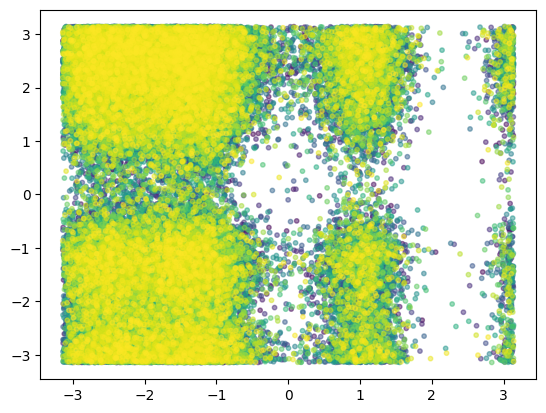

In [30]:
import mdtraj as md
import numpy as np

samples = samples.reshape(-1, energy.n_particles, energy.n_spatial_dim)
traj_samples = md.Trajectory(samples, topology=energy.topology)
phis = md.compute_phi(traj_samples)[1][:, 0]
psis = md.compute_psi(traj_samples)[1][:, 0]

plt.scatter(phis, psis, s=10, alpha=0.5, c=torch.arange(phis.shape[0]), cmap="viridis")
# plt.plot(phis, psis, markersize=5, alpha=0.5,)

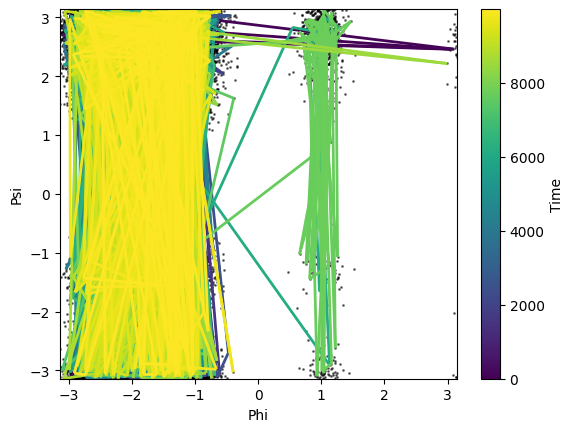

In [24]:
from matplotlib.collections import LineCollection

# Assume phis and psis are 1D arrays of same length

n_times = 10000
points = np.array([phis[:n_times], psis[:n_times]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# The "time" value can be the index of each segment
time = np.arange(n_times - 1)

lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(time.min(), time.max()))
lc.set_array(time)
lc.set_linewidth(2)

fig, ax = plt.subplots()
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax, label='Time')
ax.set_xlim(phis.min(), phis.max())
ax.set_ylim(psis.min(), psis.max())
ax.set_xlabel("Phi")
ax.set_ylabel("Psi")


ax.scatter(phis, psis, s=1, alpha=0.5, c="black")

plt.show()


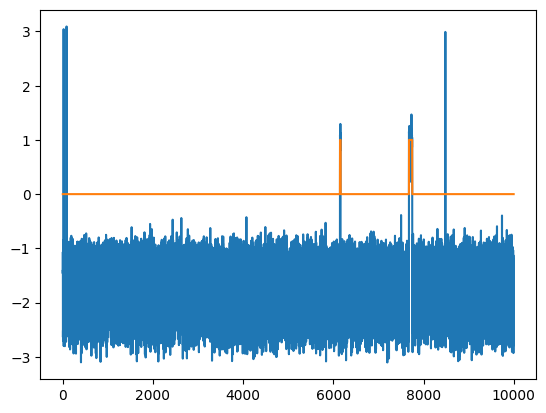

In [26]:
# trace plot
n_times_trace = 10000

bin_phi = (phis > 0) & (phis < 2)
plt.plot(phis[:n_times_trace], label="Phi")
plt.plot(bin_phi[:n_times_trace], label="Bin Phi")

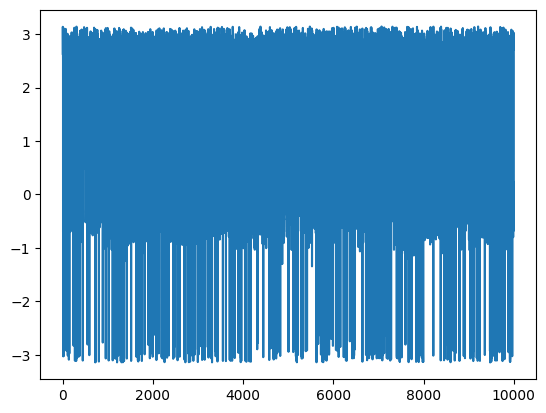

In [61]:
# trace plot
n_times_trace = 10000
plt.plot(psis[:n_times_trace], label="Psi")